![](https://images.pexels.com/photos/356807/pexels-photo-356807.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Apriltag Camera Calibration Target

Kevin J. Walchko, Phd

18 July 2020

---

A checkerboard target is one of the best calibration target for a camera. The problem becomes, you need to fit the entire target into the image. This leads to the edges not getting a large sampling and the point *coverage* mainly being in the center of the image (camera FOV).

There are many types of tags out there with various benefits and detractors. Here we are focusing on Apriltags and going to build a camera calibration board with them.

![](tags.png)



## References

- Rosebrock: [Find distance from camera to object/marker using Python and OpenCV](https://www.pyimagesearch.com/2015/01/19/find-distance-camera-objectmarker-using-python-opencv/)
- [iPhone Calibration](https://medium.com/@tomas789/iphone-calibration-camera-imu-and-kalibr-33b8645fb0aa)

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

# plotting
%matplotlib inline 

In [12]:
%matplotlib inline
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

from matplotlib import pyplot as plt
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

import time

from pupil_apriltags import Detector
import apriltag_gen as apt

import imageio
import cv2

## Helper Functions

In [13]:
def draw_tag(color_img, corners, tag_id=None):
    """
    color_img: image to draw on, must be color
    corners: corner points from apriltag detector, v[0] is the 
             lower left of the tag and the point move CCW.
    """ 
    pts = corners.reshape((-1,1,2)).astype('int32')
    cv2.polylines(color_img,[pts],True,(0,255,0),thickness=4)

    y = color_img.shape[0]
    r = max(int(y/200),1)
    c = (255,0,0)
    oc = (0,0,255)
    v = corners.astype('int32')
    cv2.circle(color_img, tuple(v[0]),r,oc,thickness=-1)
    cv2.circle(color_img, tuple(v[1]),r,c,thickness=-1)
    cv2.circle(color_img, tuple(v[2]),r,c,thickness=-1)
    cv2.circle(color_img, tuple(v[3]),r,c,thickness=-1)
    
    sz = np.abs(v[0] - v[2])
    sz = sz[0]*sz[1]
    
    if tag_id is not None:
        offset = int((v[1][0]-v[0][0])/4)
        fontScale = sz / (100 * 100 * 3)
        cv2.putText(color_img, str(tag_id),
                    org=(v[0][0]+offset,v[0][1]-offset,),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=fontScale,
                    thickness=4,
                    color=(255, 0, 255))
    
    return color_img

def draw_id(img, tags):
    """
    Draws the tag IDs on the found tags
    
    img: single color image
    tags: array of tags found in image
    """
    if len(img.shape) == 2:
        color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        color_img = img.copy()

    for tag in tags:
        color_img = draw_tag(color_img, tag.corners, tag.tag_id)
    return color_img

def draw_imgpts(img, tags):
    if len(img.shape) == 2:
        color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        color_img = img.copy()

    for t in tags:
            color_img = draw_tag(color_img, t.corners)
        
    return color_img

In [4]:
def board(marker_size, scale=10, ofw=2):
    r = marker_size[0]*marker_size[1]
    family='tag36h11'
    tags = apt.generate(family, range(r))

    ofr = 8+ofw
    ofc = 8+ofw
    r = marker_size[0]*(ofr)
    c = marker_size[1]*(ofc)
    b = np.ones((r,c))
    box = np.zeros((ofw,ofw))

    for i in range(marker_size[0]):     # rows
        for j in range(marker_size[1]): # cols
            r = i*(ofr)
            c = j*(ofc)
            x = i*marker_size[1]+j
            tag = tags[x].array
            b[r:r+8,c:c+8] = tag

    # border
    r,c = b.shape
    mm = np.ones((r+ofw, c+ofw), dtype=np.uint8)
    mm[ofw:,ofw:] = b
    
    
    for i in range(marker_size[0]+1):     # rows
        for j in range(marker_size[1]+1): # cols
            r = i*(ofr)
            c = j*(ofc)
            mm[r:r+ofw,c:c+ofw] = box
            
    mm = 255*mm

    # scale image
    xx = np.repeat(np.repeat(mm, scale, axis=0), scale, axis=1)

    return xx

## Calibration Target

Generate a target board for printing. Make sure to attach it to a flat surface for optimal performance.

In [19]:
shape = (6,8)
xx = board(shape,50)

# save it
imageio.imwrite("xx.png", xx)

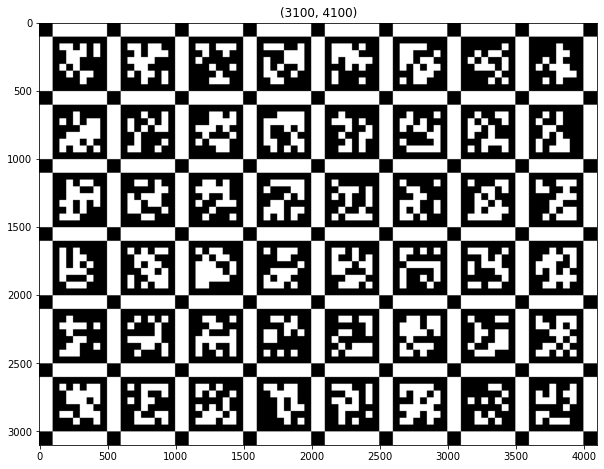

In [20]:
# for giggles, we are going to load it back in and run it through
# the detector to make sure it works
imxx = imageio.imread('xx.png')
plt.imshow(imxx, cmap="gray")
plt.title(imxx.shape);

In [17]:
d = Detector(families='tag36h11',
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0)

tags = d.detect(
    imxx, estimate_tag_pose=False, camera_params=None, tag_size=1.0)

# since our target is 6*8, we should get 48 tags found
print(f">> {len(tags)}")

# let's look at one tag ... doesn't matter which one
print(tags[1])

>> 48
Detection object:
tag_family = b'tag36h11'
tag_id = 1
hamming = 0
decision_margin = 120.0
homography = [[200.1  -0.1 800. ]
 [  0.  200.  299.9]
 [  0.   -0.    1. ]]
center = [800.  299.9]
corners = [[ 599.9  499.9]
 [1000.1  499.9]
 [1000.1   99.9]
 [ 599.9   99.9]]
pose_R = None
pose_t = None
pose_err = None



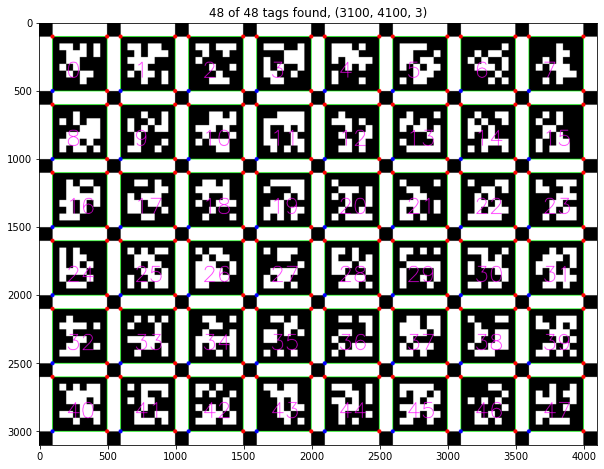

In [18]:
pp = draw_id(imxx, tags)
plt.imshow(pp)
plt.title(f"{len(tags)} of {shape[0]*shape[1]} tags found, {pp.shape}");